In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix, csr_matrix, vstack
import copy
import os
import helper
from wl import *
from joblib import Parallel, delayed
from time import time
import matplotlib.pyplot as plt
from glob import glob
import math

## Retrieve graphs from Tobias' concept-graph extraction library

In [3]:
if 0 == 1:
    GRAPH_DIR = 'extract-concept-graphs/code/data/ng20/{}_graphs'

    def get_graphs(directory):
        graphs = {}
        for topic in os.listdir(directory):
            graph_dir = os.path.join(directory, topic)
            if not os.path.isdir(graph_dir): continue
            graph_file = glob(os.path.join(graph_dir, '*.gml'))[0]
            with open(graph_file) as f:
                graph = f.read().split('\n')
            for idx, line in enumerate(graph):
                if line.startswith('label'):
                    next_line = graph[idx + 1]
                    label = next_line.replace('name', 'label')
                    graph[idx] = label
            new_graph_file = graph_file.replace('.gml', '.renamed.gml')
            with open(new_graph_file, 'w') as f:
                f.write('\n'.join(graph))
            graph = nx.read_gml(new_graph_file, label = 'label')
            if graph.number_of_nodes() > 0 and graph.number_of_edges() > 0:
                graphs[topic] = graph
            else:
                graphs[topic] = None
                print("Found empty graph: {}".format(graph_file))
        return graphs
    graphs_test_docs = get_graphs(GRAPH_DIR.format('test'))
    graphs_train_docs = get_graphs(GRAPH_DIR.format('train'))
    assert graphs_test_docs.keys() == graphs_train_docs.keys()
    assert len(graphs_test_docs.keys()) > 0

    all_nodes = [val for sublist in [g.nodes() for g in list(graphs_train_docs.values()) + list(graphs_test_docs.values()) if g is not None] for val in sublist]

In [12]:
DIR = 'data/ng-20-single-document'

def get_graphs(directory, ext = 'gml', undirected = False):
    graphs = {}
    empty_graphs = []
    files = glob(directory + '/*' + ext)
    for idx, graph_file in helper.log_progress(list(enumerate(files)), every = 100):
        topic = graph_file.split('/')[-1].split('_')[0]
        if topic not in graphs:
            graphs[topic] = []
        with open(graph_file) as f:
            graph = f.read().split('\n')
        for idx, line in enumerate(graph):
            if line.startswith('label'):
                next_line = graph[idx + 1]
                label = next_line.replace('name', 'label')
                graph[idx] = label
        try:
            graph = nx.parse_gml(graph)
            if undirected:
                graph = graph.to_undirected()
            #graph = nx.read_gml(new_graph_file, label = 'label')
            if graph.number_of_nodes() > 0 and graph.number_of_edges() > 0:
                graphs[topic].append(graph)
            else:
                empty_graphs.append(graph_file)
                #print("Found empty graph: {}".format(graph_file))
        except nx.NetworkXError as e:
            print(graph_file, e)
    print('Found empty graphs: {}'.format(len(empty_graphs)))
    return graphs
all_graphs = get_graphs(DIR, undirected = False)

Widget Javascript not detected.  It may not be installed or enabled properly.


data/ng-20-single-document/alt.atheism_0090.gml node label 'adoni' is duplicated
data/ng-20-single-document/alt.atheism_0461.gml node label 'mating practices' is duplicated
data/ng-20-single-document/comp.graphics_0238.gml node label 'hips' is duplicated
data/ng-20-single-document/comp.graphics_0274.gml node label 'avs' is duplicated
data/ng-20-single-document/comp.graphics_0435.gml node label 'iges' is duplicated
data/ng-20-single-document/comp.graphics_0441.gml node label 'hips' is duplicated
data/ng-20-single-document/comp.graphics_0679.gml node label 'arithmetic coding' is duplicated
data/ng-20-single-document/comp.graphics_0687.gml node label 'arithmetic coding' is duplicated
data/ng-20-single-document/comp.graphics_0773.gml node label 'otis' is duplicated
data/ng-20-single-document/comp.graphics_0938.gml node label 'arithmetic coding' is duplicated
data/ng-20-single-document/comp.sys.ibm.pc.hardware_0728.gml node label 'the wd1002a-wx1' is duplicated
data/ng-20-single-document/co

20

In [5]:
REMOVE_CATEGORIES = ('misc.forsale')
graphs = all_graphs.copy()
if len(REMOVE_CATEGORIES):
    del graphs[REMOVE_CATEGORIES]
print(graphs.keys())

dict_keys(['comp.windows.x', 'talk.politics.guns', 'comp.os.ms-windows.misc', 'rec.autos', 'alt.atheism', 'rec.sport.baseball', 'comp.graphics', 'sci.med', 'comp.sys.mac.hardware', 'talk.politics.mideast', 'sci.electronics', 'comp.sys.ibm.pc.hardware', 'soc.religion.christian', 'talk.politics.misc', 'rec.motorcycles', 'talk.religion.misc', 'sci.crypt', 'rec.sport.hockey', 'sci.space'])


In [6]:
import functools

all_nodes = set()
for gs in graphs.values():
    all_nodes |= functools.reduce(lambda acc, x: acc | set(x), [x.nodes() for x in gs], set())
print('Unique tokens found: {}'.format(len(all_nodes)))

Unique tokens found: 123068


## Some helper

In [7]:
def get_wl_for_graphs(graphs, all_nodes = all_nodes,  h = 10, fn = WL_compute):
    nodes = [sorted(g.nodes()) for g in graphs]
    adjs = [nx.adjacency_matrix(g, nodelist = sorted(g.nodes())).toarray() for g in graphs]
    return fn(adjs, nodes, all_nodes = all_nodes, h = h)

In [30]:
graphs_as_list = functools.reduce(lambda acc, x: acc + [(x[0], y) for y in x[1]], graphs.items(), [])
print('Graphs: {}'.format(len(graphs_as_list)))

def get_train_test_split(topic_graphs, train_split_ratio = 0.8):
    train = []
    test = []
    num_elements = {}
    for topic, graphs in topic_graphs.items():
        num_elements_train = int(len(graphs) * train_split_ratio)
        num_elements[topic] = num_elements_train
        train += [(topic, x) for x in graphs[:num_elements_train]]
        test += [(topic, x) for x in graphs[num_elements_train:]]
    return train, test, num_elements

train, test, num_elements = get_train_test_split(graphs)

Graphs: 14060


In [23]:
{topic: len(graphs) for topic, graphs in train}

{'alt.atheism': 7,
 'comp.graphics': 2,
 'comp.os.ms-windows.misc': 14,
 'comp.sys.ibm.pc.hardware': 11,
 'comp.sys.mac.hardware': 4,
 'comp.windows.x': 2,
 'rec.autos': 89,
 'rec.motorcycles': 8,
 'rec.sport.baseball': 16,
 'rec.sport.hockey': 7,
 'sci.crypt': 4,
 'sci.electronics': 17,
 'sci.med': 5,
 'sci.space': 2,
 'soc.religion.christian': 4,
 'talk.politics.guns': 4,
 'talk.politics.mideast': 7,
 'talk.politics.misc': 6,
 'talk.religion.misc': 13}

In [9]:
H = 2

## Calculate gram-matrix for WL kernel for the training concept-graphs

In [10]:
#%%time
from sklearn import svm
import psutil

adjs = []
nodes = []
for topic, graph in train:
    sorted_nodes = sorted(graph.nodes())
    adjs.append(nx.adjacency_matrix(graph, nodelist = sorted_nodes))
    nodes.append(sorted_nodes)

In [14]:
print('Calculating WL_train: start', psutil.virtual_memory())
K_train, phi_list_train, label_lookup_train, label_counters_train = WL_compute(adjs, nodes, H, all_nodes = all_nodes, DEBUG = True, compute_k = False)
print('Calculating WL_train: end', psutil.virtual_memory())

Calculating WL_train: start svmem(total=8589934592, available=3352440832, percent=61.0, used=5274263552, free=2964090880, active=3371515904, inactive=388349952, wired=1514397696)
Number of original labels 123112
K original is computed
Iteration 0: phi is computed
	Graph          0/11240
	Graph       1000/11240
	Graph       2000/11240
	Graph       3000/11240
	Graph       4000/11240
	Graph       5000/11240
	Graph       6000/11240
	Graph       7000/11240
	Graph       8000/11240
	Graph       9000/11240
	Graph      10000/11240
	Graph      11000/11240
Number of compressed labels 124908
Itaration 0: phi computed
Iteration 1: phi is computed
	Graph          0/11240
	Graph       1000/11240
	Graph       2000/11240
	Graph       3000/11240
	Graph       4000/11240
	Graph       5000/11240
	Graph       6000/11240
	Graph       7000/11240
	Graph       8000/11240
	Graph       9000/11240
	Graph      10000/11240
	Graph      11000/11240
Number of compressed labels 125207
Itaration 1: phi computed
Calculati

## Train SVM classifier on the gram-matrix

In [15]:
import sklearn
#clf = svm.SVC(kernel = 'precomputed', verbose = True, probability=True)
clf = sklearn.linear_model.Perceptron(n_iter = 100, verbose = True, n_jobs = -1)

'''
batches = 100
num_elements_per_batch = int(len(train) / 10)
for start in range(batches):
    start = start * num_elements_per_batch
    end = min(len(train), start +
              num_elements_per_batch)
    print('Iteration: {}, #Elements: {}'.format(start, end - start))
    if end - start == 0:
        break
'''
X = phi_list_train[-1].T
Y = [topic for topic, graphs in train]
clf.fit(X, Y)


-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1-- Epoch 1







Norm: 112.80, NNZs: 12627, Bias: -0.080000, T: 11240, Avg. loss: 0.041173Norm: 97.91, NNZs: 9559, Bias: -0.010000, T: 11240, Avg. loss: 0.020014Norm: 108.64, NNZs: 11754, Bias: -0.010000, T: 11240, Avg. loss: 0.025967Norm: 93.75, NNZs: 8762, Bias: -0.020000, T: 11240, Avg. loss: 0.019456Norm: 98.15, NNZs: 9604, Bias: -0.010000, T: 11240, Avg. loss: 0.026511Norm: 106.60, NNZs: 11310, Bias: -0.010000, T: 11240, Avg. loss: 0.020089Norm: 101.91, NNZs: 10371, Bias: -0.030000, T: 11240, Avg. loss: 0.025816Norm: 102.83, NNZs: 10515, Bias: 0.000000, T: 11240, Avg. loss: 0.027535







Total training time: 0.02 seconds.Total training time: 0.01 seconds.Total training time: 0.03 seconds.Total training time: 0.02 seconds.Total training time: 0.02 seconds.Total training time: 0.01 seconds.Total training time: 0.01 seconds.Total training time: 0.02 seconds.







-- Epoch 2-- Epoch 2-- Epoch 2-- Epoch 2-- Epoc

Norm: 125.57, NNZs: 15477, Bias: -1.000000, T: 202320, Avg. loss: 0.002779Norm: 105.91, NNZs: 11183, Bias: -0.620000, T: 202320, Avg. loss: 0.001549Norm: 115.83, NNZs: 13342, Bias: -0.730000, T: 202320, Avg. loss: 0.001813Norm: 98.38, NNZs: 9630, Bias: -0.430000, T: 202320, Avg. loss: 0.001393
Norm: 112.29, NNZs: 12529, Bias: -0.460000, T: 202320, Avg. loss: 0.001442Norm: 107.29, NNZs: 11487, Bias: -0.620000, T: 202320, Avg. loss: 0.001737Norm: 108.46, NNZs: 11686, Bias: -0.420000, T: 202320, Avg. loss: 0.003132



Norm: 103.33, NNZs: 10620, Bias: -0.520000, T: 202320, Avg. loss: 0.003056


Total training time: 0.35 seconds.Total training time: 0.30 seconds.Total training time: 0.33 seconds.Total training time: 0.30 seconds.
Total training time: 0.30 seconds.Total training time: 0.31 seconds.Total training time: 0.33 seconds.



Total training time: 0.31 seconds.


-- Epoch 19-- Epoch 19-- Epoch 19-- Epoch 19
-- Epoch 19-- Epoch 19-- Epoch 19



-- Epoch 19


Norm: 125.57, NNZs: 15477,


-- Epoch 46-- Epoch 46
-- Epoch 46
-- Epoch 46-- Epoch 46-- Epoch 46

-- Epoch 46
-- Epoch 46


Norm: 125.57, NNZs: 15477, Bias: -1.000000, T: 517040, Avg. loss: 0.001088Norm: 105.91, NNZs: 11183, Bias: -0.620000, T: 517040, Avg. loss: 0.000606
Norm: 98.38, NNZs: 9630, Bias: -0.430000, T: 517040, Avg. loss: 0.000545
Norm: 112.29, NNZs: 12529, Bias: -0.460000, T: 517040, Avg. loss: 0.000564Norm: 107.29, NNZs: 11487, Bias: -0.620000, T: 517040, Avg. loss: 0.000680Norm: 108.45, NNZs: 11683, Bias: -0.430000, T: 517040, Avg. loss: 0.002048

Norm: 115.83, NNZs: 13342, Bias: -0.730000, T: 517040, Avg. loss: 0.000710
Norm: 103.36, NNZs: 10626, Bias: -0.520000, T: 517040, Avg. loss: 0.001969


Total training time: 0.88 seconds.Total training time: 0.82 seconds.
Total training time: 0.83 seconds.
Total training time: 0.76 seconds.Total training time: 0.79 seconds.Total training time: 0.82 seconds.

Total training time: 0.87 seconds.
Total training time: 0.78 seconds.


-- Epoch 47-- Epoch 47
--

-- Epoch 20-- Epoch 20-- Epoch 20


Norm: 131.88, NNZs: 17011, Bias: -1.000000, T: 224800, Avg. loss: 0.003609Norm: 152.03, NNZs: 22516, Bias: -1.000000, T: 224800, Avg. loss: 0.003735


Norm: 112.53, NNZs: 12520, Bias: -0.660000, T: 224800, Avg. loss: 0.002143Norm: 124.47, NNZs: 15366, Bias: -0.940000, T: 224800, Avg. loss: 0.002094Norm: 126.98, NNZs: 15869, Bias: -0.980000, T: 224800, Avg. loss: 0.002682

Norm: 102.73, NNZs: 10514, Bias: -0.510000, T: 224800, Avg. loss: 0.001655Norm: 133.63, NNZs: 17539, Bias: -1.010000, T: 224800, Avg. loss: 0.003125Norm: 109.51, NNZs: 11835, Bias: -0.600000, T: 224800, Avg. loss: 0.001937


Total training time: 0.33 seconds.Total training time: 0.31 seconds.


Total training time: 0.37 seconds.Total training time: 0.33 seconds.Total training time: 0.34 seconds.

Total training time: 0.32 seconds.Total training time: 0.32 seconds.Total training time: 0.33 seconds.


-- Epoch 21-- Epoch 21


-- Epoch 21-- Epoch 21-- Epoch 21

-- Epoch 21-- Epoch 21--

[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    4.2s finished


Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=100, n_jobs=-1, penalty=None, random_state=0, shuffle=True,
      verbose=True, warm_start=False)

-- Epoch 91-- Epoch 91


-- Epoch 91-- Epoch 91-- Epoch 91

-- Epoch 91-- Epoch 91-- Epoch 91


Norm: 131.88, NNZs: 17011, Bias: -1.000000, T: 1022840, Avg. loss: 0.000793Norm: 152.03, NNZs: 22516, Bias: -1.000000, T: 1022840, Avg. loss: 0.000821


Norm: 112.53, NNZs: 12520, Bias: -0.660000, T: 1022840, Avg. loss: 0.000671Norm: 124.47, NNZs: 15366, Bias: -0.940000, T: 1022840, Avg. loss: 0.000460Norm: 126.98, NNZs: 15869, Bias: -0.980000, T: 1022840, Avg. loss: 0.000589

Norm: 102.73, NNZs: 10514, Bias: -0.510000, T: 1022840, Avg. loss: 0.000626Norm: 133.92, NNZs: 17587, Bias: -1.010000, T: 1022840, Avg. loss: 0.000875Norm: 109.51, NNZs: 11835, Bias: -0.600000, T: 1022840, Avg. loss: 0.000626


Total training time: 1.49 seconds.Total training time: 1.51 seconds.


Total training time: 1.54 seconds.Total training time: 1.52 seconds.Total training time: 1.55 seconds.

Total training time: 1.51 seconds.Total training time: 1.51 seconds.Total training time: 1.49 seconds.


-- Epoch 92-- Ep

In [16]:
def get_prediction(topic, graph):
    return compute_phi(graph, phi_list_train[0].shape, label_lookup_train, label_counters_train, h = H)[-1]

USED_SET = test
PARALLEL_PREDICTION_JOBS = 0
t = time()

if PARALLEL_PREDICTION_JOBS > 1:
    phi_test = Parallel(n_jobs=PARALLEL_PREDICTION_JOBS)(delayed(get_prediction)(*d) for d in list(USED_SET))
else:
    phi_test = [get_prediction(*d) for d in USED_SET]
print('Time: {:.2f}s'.format(time() - t, PARALLEL_PREDICTION_JOBS))

Total training time: 1.51 seconds.Total training time: 1.52 seconds.


Total training time: 1.56 seconds.Total training time: 1.54 seconds.Total training time: 1.56 seconds.

Total training time: 1.52 seconds.Total training time: 1.53 seconds.Total training time: 1.52 seconds.


-- Epoch 93-- Epoch 93


-- Epoch 93-- Epoch 93-- Epoch 93

-- Epoch 93-- Epoch 93-- Epoch 93


Norm: 131.88, NNZs: 17011, Bias: -1.000000, T: 1045320, Avg. loss: 0.000776Norm: 152.03, NNZs: 22516, Bias: -1.000000, T: 1045320, Avg. loss: 0.000803


Norm: 112.54, NNZs: 12524, Bias: -0.650000, T: 1045320, Avg. loss: 0.000661Norm: 124.47, NNZs: 15366, Bias: -0.940000, T: 1045320, Avg. loss: 0.000450Norm: 126.98, NNZs: 15869, Bias: -0.980000, T: 1045320, Avg. loss: 0.000577

Norm: 102.72, NNZs: 10513, Bias: -0.510000, T: 1045320, Avg. loss: 0.000620Norm: 133.91, NNZs: 17589, Bias: -1.020000, T: 1045320, Avg. loss: 0.000860Norm: 109.49, NNZs: 11831, Bias: -0.610000, T: 1045320, Avg. loss: 0.000619


Total training t

Norm: 139.73, NNZs: 19143, Bias: -1.010000, T: 741840, Avg. loss: 0.001072Norm: 139.72, NNZs: 18900, Bias: -1.000000, T: 741840, Avg. loss: 0.000865Total training time: 0.52 seconds.


Total training time: 0.55 seconds.Total training time: 0.56 seconds.-- Epoch 67


-- Epoch 67-- Epoch 67Norm: 123.47, NNZs: 14979, Bias: -1.000000, T: 753080, Avg. loss: 0.000979


Norm: 139.73, NNZs: 19143, Bias: -1.010000, T: 753080, Avg. loss: 0.001056Norm: 139.72, NNZs: 18900, Bias: -1.000000, T: 753080, Avg. loss: 0.000852Total training time: 0.53 seconds.


Total training time: 0.55 seconds.Total training time: 0.57 seconds.-- Epoch 68


-- Epoch 68-- Epoch 68Norm: 123.47, NNZs: 14979, Bias: -1.000000, T: 764320, Avg. loss: 0.000965


Norm: 139.73, NNZs: 19143, Bias: -1.010000, T: 764320, Avg. loss: 0.001041Norm: 139.72, NNZs: 18900, Bias: -1.000000, T: 764320, Avg. loss: 0.000839Total training time: 0.54 seconds.


Total training time: 0.56 seconds.Total training time: 0.57 seconds.-- Epoch 69


-

In [17]:
import gc
gc.collect()

6

In [18]:
%%time
def calculate_batches(l, fn, num_batches = 100):
    elements = []
    num_elements_per_batch = math.ceil(len(l) / num_batches)
    print('Starting: #elements: {}, #batches: {}, #elements per Batch: {}'.format(len(l), num_batches, num_elements_per_batch))
    for idx in range(num_batches):
        start = idx * num_elements_per_batch
        end = min(len(l), start + num_elements_per_batch)
        if idx % 10 == 0: print('\tIteration: {:>4}/{}'.format(idx, num_batches))
        if end - start <= 0:
            break
        elements += fn(l[start:end]).tolist()
    return elements
predicted = calculate_batches(phi_test, clf.predict)

Starting: #elements: 2820, #batches: 100, #elements per Batch: 29
	Iteration:    0/100
	Iteration:   10/100
	Iteration:   20/100
	Iteration:   30/100
	Iteration:   40/100
	Iteration:   50/100
	Iteration:   60/100
	Iteration:   70/100
	Iteration:   80/100
	Iteration:   90/100
CPU times: user 5.86 s, sys: 2.42 s, total: 8.27 s
Wall time: 8.33 s


In [19]:
Y_real = [topic for topic,graph in USED_SET]
Y_pred = predicted

sklearn.metrics.accuracy_score(Y_real, Y_pred), sklearn.metrics.f1_score(Y_real, Y_pred, average='macro')

(0.26879432624113475, 0.30008650831721478)

['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball' 'rec.sport.hockey'
 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


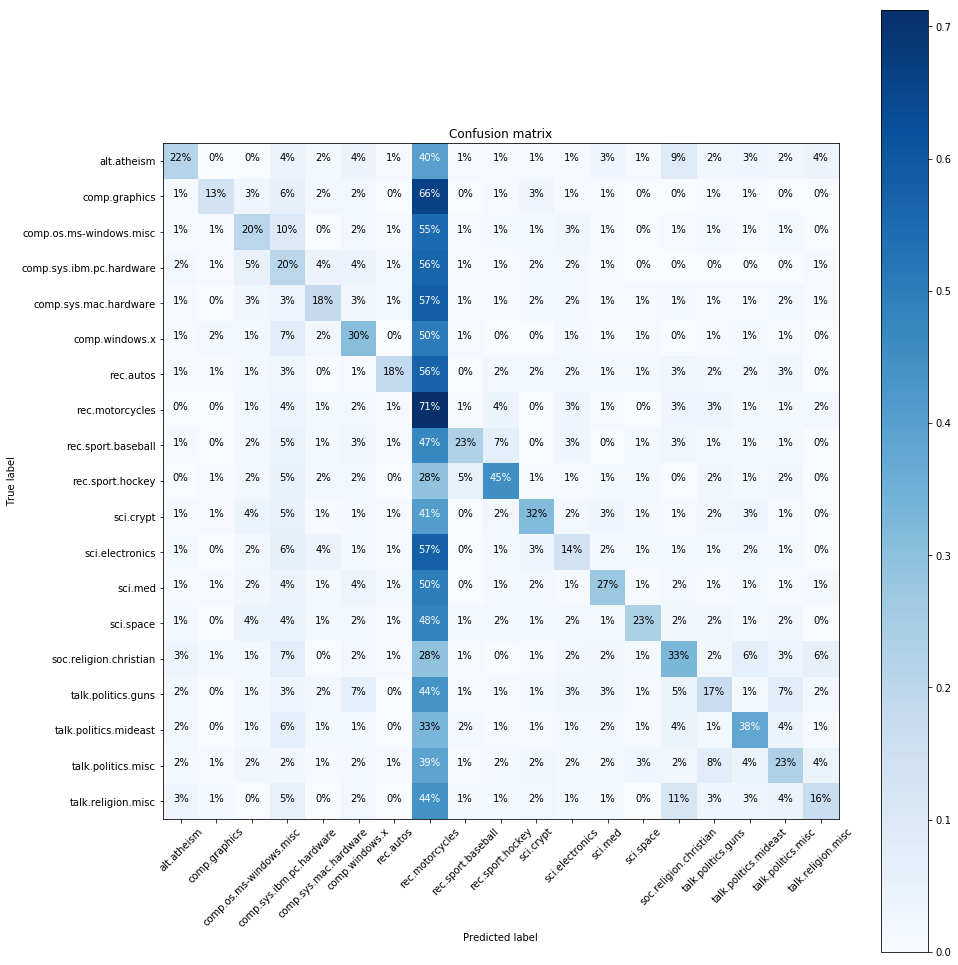

In [20]:
cf_mat = sklearn.metrics.confusion_matrix(Y_real, Y_pred)

fig = plt.figure(figsize=(14, 14))
helper.plot_confusion_matrix(cf_mat, clf.classes_, normalize = True)
plt.show()

In [21]:
import pickle

with open('data/graphs.npy', 'wb') as f:
    pickle.dump({
            'train': train,
            'test': test,
            'K_train': K_train,
            'phi_list_train': phi_list_train,
            'label_lookup_train': label_lookup_train,
            'label_counters_train': label_counters_train
    }, f)

## Test classifier

In [22]:
%store all_graphs_test
%store all_graphs_train
%store K_train
%store phi_list_train
%store label_counters_train
%store label_lookup_train

UsageError: Unknown variable 'all_graphs_test'


## Draw graphs

In [ ]:
if 0 == 1:
    fig = plt.figure(figsize=(30, 30))
    pos=nx.spring_layout(g_mult_dir)
    nx.draw(g_mult_dir, pos = pos)

    edge_labels=dict([((u,v,),d['name'])
                 for u,v,d in g_mult_dir.edges(data=True)])
    nx.draw_networkx_edge_labels(g_mult_dir,pos,edge_labels=edge_labels)
    nx.draw_networkx_nodes(g_mult_dir, pos = pos, label='name', )
    nx.draw_networkx_labels(g_mult_dir, pos = pos)
    plt.show()

    graphs = sorted(list(nx.weakly_connected_component_subgraphs(g_mult_dir)), key = len)#, reverse = True)

    for graph in graphs[-4:]:
        fig = plt.figure(figsize=(20, 20))
        pos=nx.spring_layout(graph)
        #nx.draw(graph, pos = pos)
        edge_labels=dict([((u,v,),d['name'])
                     for u,v,d in graph.edges(data=True)])
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        nx.draw_networkx_edges(graph, pos, arrows = True)
        nx.draw_networkx_nodes(graph, pos = pos, label='name')
        nx.draw_networkx_labels(graph, pos = pos)
        plt.show()
